1. Load required packages

In [1]:
import warnings
import calmap
import pickle
import random
import time
import os
from plotly_calplot import calplot
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from yellowbrick.features import Rank2D
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier import ClassificationReport
from sklearn.model_selection import train_test_split
from yellowbrick.target import ClassBalance
from yellowbrick.target import class_balance
from sklearn import tree
from xgboost import XGBClassifier,plot_importance
from IPython.display import Image

warnings.filterwarnings('ignore')

sns.set_theme(style="darkgrid")
current_palette = sns.color_palette()


In [2]:
pd.options.display.min_rows = 20
pd.options.display.max_columns = 500


Machine Learning Process

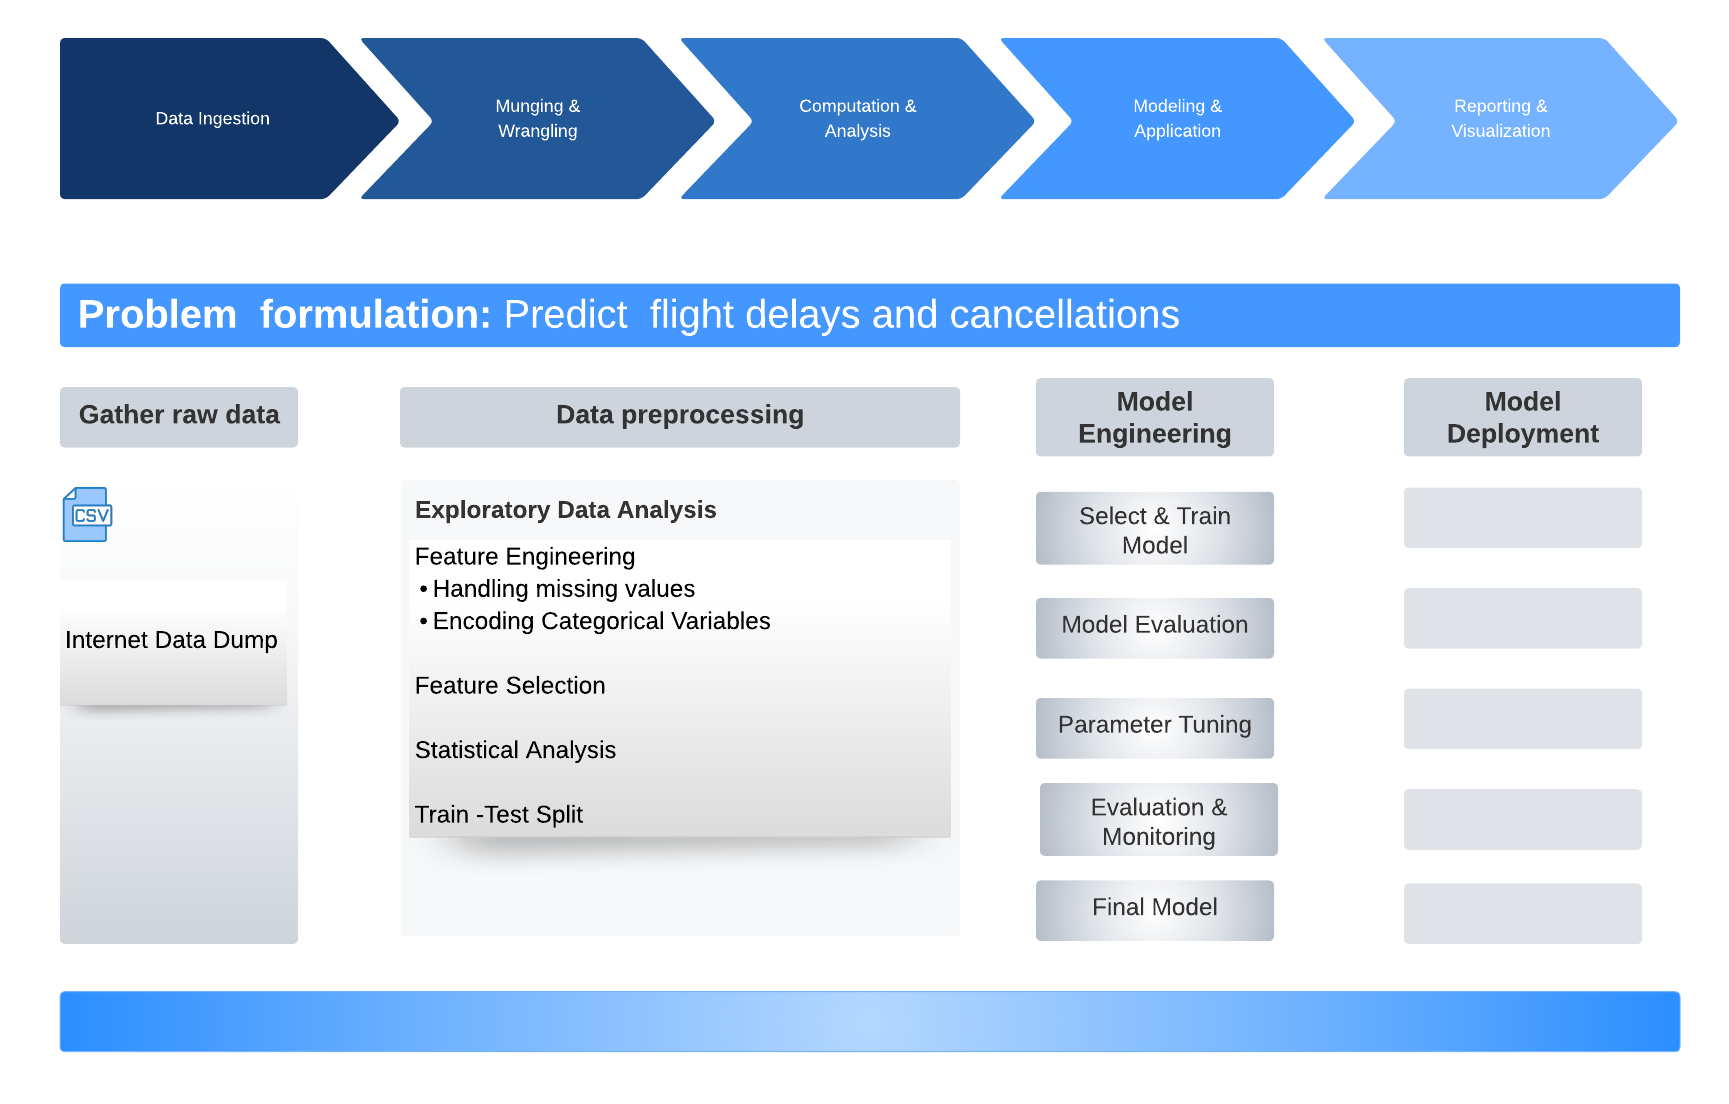

In [3]:
Image("../../../data/images/MLProcess.png")

### Load in the data

In [4]:
n= 40000000
s= 1000000
skip = sorted(random.sample(range(1,n),n-s))
df_flights = pd.read_csv("../../../data/eda/flights/all_flight_data_20182019_20212022/all_flight_data_20182022NC.zip",skiprows=skip, low_memory=False, encoding="iso-8859-1")

In [5]:
df_flights = df_flights.rename(columns={"Operating_Airline ": "Operating_Airline", "Flight_Number_Operating_Airline": "Flight_Number"})

In [6]:
airlines = pd.read_csv(
    "../../../data/databases/flight_attributes/airlines.csv.zip", low_memory=False)
airline_mapper = airlines.set_index("Code")["Description"]

In [7]:
cancellation_codes = pd.read_csv(
    "../../../data/databases/flight_attributes/cancellation_codes.csv", low_memory=False)
cancellation_code_mapper = cancellation_codes.set_index(
    "CANCELLATION_REASON")["CANCELLATION_DESCRIPTION"]


In [8]:
usa_airports = (pd.read_csv("../../../data/databases/flight_attributes/usa_airports.csv.zip",
                            usecols= ["iata","latitude","longitude"], 
                            low_memory=False))
usa_airports = usa_airports.rename(columns={"iata": "Origin"})



In [9]:
df_flights.head()

,Unnamed: 0,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Originally_Scheduled_Code_Share_Airline,DOT_ID_Originally_Scheduled_Code_Share_Airline,IATA_Code_Originally_Scheduled_Code_Share_Airline,Flight_Num_Originally_Scheduled_Code_Share_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,DivAirportLandings,DivReachedDest,DivActualElapsedTime,DivArrDelay,DivDistance,Div1Airport,Div1AirportID,Div1AirportSeqID,Div1WheelsOn,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime,Div2WheelsOff,Div2TailNum,Div3Airport,Div3AirportID,Div3AirportSeqID,Div3WheelsOn,Div3TotalGTime,Div3LongestGTime,Div3WheelsOff,Div3TailNum,Div4Airport,Div4AirportID,Div4AirportSeqID,Div4WheelsOn,Div4TotalGTime,Div4LongestGTime,Div4WheelsOff,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Duplicate,Unnamed: 119
0,23,2018,1,1,17,3,2018-01-17,DL,DL_CODESHARE,19790,DL,3298,NaN,NaN,NaN,NaN,9E,20363,9E,N8972E,3298,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,10146,1014602,30146,ABY,"Albany, GA",GA,13,Georgia,34,1037,NaN,NaN,NaN,NaN,NaN,1000-1059,NaN,NaN,NaN,NaN,1137,NaN,NaN,NaN,NaN,NaN,1100-1159,1.0,C,0.0,60.0,NaN,NaN,1.0,145.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
1,98,2018,1,1,20,6,2018-01-20,DL,DL_CODESHARE,19790,DL,3300,NaN,NaN,NaN,NaN,9E,20363,9E,N836AY,3300,12953,1295304,31703,LGA,"New York, NY",NY,36,New York,22,15096,1509602,35096,SYR,"Syracuse, NY",NY,36,New York,22,1810,1758.0,-12.0,0.0,0.0,-1.0,1800-1859,24.0,1822.0,1857.0,6.0,1928,1903.0,-25.0,0.0,0.0,-2.0,1900-1959,0.0,NaN,0.0,78.0,65.0,35.0,1.0,198.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
2,195,2018,1,1,18,4,2018-01-18,DL,DL_CODESHARE,19790,DL,3302,NaN,NaN,NaN,NaN,9E,20363,9E,N8918B,3302,11641,1164102,31641,FAY,"Fayetteville, NC",NC,37,North Carolina,36,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,1853,1850.0,-3.0,0.0,0.0,-1.0,1800-1859,14.0,1904.0,2005.0,16.0,2030,2021.0,-9.0,0.0,0.0,-1.0,2000-2059,0.0,NaN,0.0,97.0,91.0,61.0,1.0,331.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
3,208,2018,1,1,20,6,2018-01-20,DL,DL_CODESHARE,19790,DL,3302,NaN,NaN,NaN,NaN,9E,20363,9E,N331PQ,3302,13487,1348702,31650,MSP,"Minneapolis, MN",MN,27,Minnesota,63,11066,1106606,31066,CMH,"Columbus, OH",OH,39,Ohio,44,1536,1530.0,-6.0,0.0,0.0,-1.0,1500-1559,23.0,1553.0,1813.0,5.0,1830,1818.0,-12.0,0.0,0.0,-1.0,1800-1859,0.0,NaN,0.0,114.0,108.0,80.0,1.0,626.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

### Data Pre-processing Phase
- EDA
- Feature Engineering
  - Handling missing values
  - Encoding Categorical Variables
  - Feature creation
  - Handling of imbalanced classes in dataset
- Feature Selection 
- Statistical Analysis
- Train - Test Split

In [10]:
#df_flights.dtypes

In [11]:
df_flights.dtypes

Unnamed: 0                                   int64
Year                                         int64
Quarter                                      int64
Month                                        int64
DayofMonth                                   int64
DayOfWeek                                    int64
FlightDate                                  object
Marketing_Airline_Network                   object
Operated_or_Branded_Code_Share_Partners     object
DOT_ID_Marketing_Airline                     int64
                                            ...   
Div5Airport                                float64
Div5AirportID                              float64
Div5AirportSeqID                           float64
Div5WheelsOn                               float64
Div5TotalGTime                             float64
Div5LongestGTime                           float64
Div5WheelsOff                              float64
Div5TailNum                                float64
Duplicate                      

In [12]:
def airline_mapping(df_flights):
    df_flights["Operating_Airline"] = (
        df_flights["Operating_Airline"].map(airline_mapper))
    df_flights["CancellationCode"] = (
        df_flights["CancellationCode"].map(cancellation_code_mapper))
    return df_flights

##########Flight Status Categories####################
###############DepDelayGroups#########################
# Departure Delay intervals until 180 mins
def DepDelay_Class(df_flights):
    df_flights["DepDelayClass"] = None
    df_flights.loc[df_flights["DepDelayMinutes"] <= 0.5, "DepDelayClass"] = "OnTime"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 0.5), "DepDelayClass"] = "Delayed"
    df_flights.loc[(df_flights["Cancelled"] > 0), "DepDelayClass"] = "Delayed"
    return df_flights

def tweak_df_flights(df_flights):
    DepDelay_Class(df_flights)
    SELECTED_COLUMNS = ["FlightDate", "Operating_Airline", "Tail_Number", "Flight_Number", "OriginAirportID",
                        "Origin", "OriginCityName", "OriginState", "OriginStateName", "DestAirportID", "Dest", "DestCityName",
                        "DestState", "DestStateName", "CRSDepTime", "DepTime", "DepDelay", "DepDel15", "DepDelayMinutes", "DepTimeBlk",
                        "TaxiOut", "WheelsOn", "TaxiIn", "CRSArrTime", "ArrTime", "ArrDelayMinutes", "ArrDel15", "ArrTimeBlk",
                        "Cancelled", "CancellationCode", "Diverted", "CRSElapsedTime", "AirTime", "Distance", "CarrierDelay",
                        "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "FirstDepTime", "TotalAddGTime","DepDelayClass"
                        ]
    df_flights = (
        df_flights[SELECTED_COLUMNS]
        .copy()
    )
    df_flights = (pd.merge(df_flights, usa_airports, how="left", on=["Origin"]))
    df_flights.pipe(airline_mapping)
    return df_flights.assign(
        DepTime=df_flights.DepTime.fillna(0).astype("float16"),
        DepDelay=df_flights.DepDelay.fillna(0).astype("float16"),
        DepDel15=df_flights.DepDel15.fillna(0).astype("float16"),
        DepDelayMinutes=df_flights.DepDelayMinutes.fillna(0).astype("float16"),
        TaxiOut=df_flights.TaxiOut.fillna(0).astype("float16"),
        WheelsOn=df_flights.WheelsOn.fillna(0).astype("float16"),
        TaxiIn=df_flights.TaxiIn.fillna(0).astype("float16"),
        ArrDel15=df_flights.ArrDel15.fillna(0).astype("float16"),
        ArrDelayMinutes=df_flights.ArrDelayMinutes.fillna(0).astype("float16"),
        CRSElapsedTime=df_flights.CRSElapsedTime.fillna(0).astype("float16"),
        ArrTime=df_flights.ArrTime.fillna(0).astype("float16"),
        AirTime=df_flights.AirTime.fillna(0).astype("float16"),
        Distance=df_flights.Distance.fillna(0).astype("float16"),
        CarrierDelay=df_flights.CarrierDelay.fillna(0).astype("float16"),
        WeatherDelay=df_flights.WeatherDelay.fillna(0).astype("float16"),
        NASDelay=df_flights.NASDelay.fillna(0).astype("float16"),
        SecurityDelay=df_flights.SecurityDelay.fillna(0).astype("float16"),
        LateAircraftDelay=df_flights.LateAircraftDelay.fillna(
            0).astype("float16"),
        FirstDepTime=df_flights.FirstDepTime.fillna(0).astype("float16"),
        TotalAddGTime=df_flights.TotalAddGTime.fillna(0).astype("float16"),
        CancellationCode=df_flights.CancellationCode.fillna(
            "none").astype("category"),
        Tail_Number=df_flights.Tail_Number.fillna("none").astype("category"),
        FlightDate=pd.to_datetime(df_flights.FlightDate)
    ).astype(
        {
            "Operating_Airline": "category",
            "Origin": "category",
            "Dest": "category",
            "DestState": "category",
            "OriginState": "category",
            "OriginCityName": "category",
            "OriginStateName": "category",
            "DestStateName": "category",
            "DestCityName": "category",
            "DepTimeBlk": "category",
            "ArrTimeBlk": "category",
            "Cancelled": "int16",
            "Diverted": "bool",
            "OriginAirportID": "int16",
            "DestAirportID": "int16",
            "CRSDepTime": "int16",
            "CRSArrTime": "int16",
            "Flight_Number": "int16",
            "latitude": "float16",
            "longitude": "float16",
            "DepDelayClass": "category"
        }
    )


df_flights = tweak_df_flights(df_flights)

print(df_flights.shape)
df_flights.tail()


(619266, 44)


,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,DepDelayClass,latitude,longitude
619261,2022-08-01,Comair Inc.,N601EN,5290,11995,GSO,"Greensboro/High Point, NC",NC,North Carolina,11057,CLT,"Charlotte, NC",NC,North Carolina,1810,1933.0,83.0,1.0,83.0,1800-1859,25.0,2023.0,5.0,1906,2028.0,82.0,1.0,1900-1959,0,none,False,56.0,25.0,83.0,0.0,0.0,0.0,0.0,82.0,0.0,0.0,Delayed,36.09375,-79.9375
619262,2022-08-05,Comair Inc.,N574NN,5291,11057,CLT,"Charlotte, NC",NC,North Carolina,12448,JAN,"Jackson/Vicksburg, MS",MS,Mississippi,2240,2236.0,-4.0,0.0,0.0,2200-2259,19.0,2312.0,7.0,2342,2320.0,0.0,0.0,2300-2359,0,none,False,122.0,77.0,562.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,35.21875,-80.9375
619263,2022-08-01,Comair Inc.,N544EA,5292,11057,CLT,"Charlotte, NC",NC,North Carolina,15412,TYS,"Knoxville, TN",TN,Tennessee,2040,2033.0,-7.0,0.0,0.0,2000-2059,22.0,2130.0,6.0,2142,2136.0,0.0,0.0,2100-2159,0,none,False,62.0,35.0,177.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,35.21875,-80.9375
619264,2022-08-18,Comair Inc.,N601EN,5294,11278,DCA,"Washington, DC",VA,Virginia,12323,ILM,"Wilmington, NC",NC,North Carolina,834,828.0,-6.0,0.0,0.0,0800-0859,26.0,956.0,7.0,1006,1003.0,0.0,0.0,1000-1059,0,none,False,92.0,62.0,319.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,38.84375,-77.0625
619265,2022-08-18,Comair Inc.,N563NN,5295,10994,CHS,"Charleston, SC",SC,South Carolina,14100,PHL,"Philadelphia, PA",PA,Pennsylvania,742,735.0,-7.0,0.0,0.0,0700-0759,20.0,911.0,3.0,931,914.0,0.0,0.0,0900-0959,0,none,False,109.0,76.0,550.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,32.90625,-80.0625


In [13]:
#df_flights.describe()

In [14]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619266 entries, 0 to 619265
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   FlightDate         619266 non-null  datetime64[ns]
 1   Operating_Airline  619266 non-null  category      
 2   Tail_Number        619266 non-null  category      
 3   Flight_Number      619266 non-null  int16         
 4   OriginAirportID    619266 non-null  int16         
 5   Origin             619266 non-null  category      
 6   OriginCityName     619266 non-null  category      
 7   OriginState        619266 non-null  category      
 8   OriginStateName    619266 non-null  category      
 9   DestAirportID      619266 non-null  int16         
 10  Dest               619266 non-null  category      
 11  DestCityName       619266 non-null  category      
 12  DestState          619266 non-null  category      
 13  DestStateName      619266 non-null  category

In [15]:

# Handling Ordinal Categorical Variables [Label Encoding]
# assign the feature with ranks [Ordinal numbering encoding (Label Encoding)]
# engineer categorical variable by ordinal number replacement
DepDelayClass_mapping = {
    'OnTime': '0',
    'Delayed': '1'
    }

df_flights["DepDelayClass_ordinal"] = df_flights.DepDelayClass.map(DepDelayClass_mapping)

df_flights["DepDelayClass_ordinal"] = df_flights["DepDelayClass_ordinal"].astype("float16")


print(df_flights.shape)
df_flights.tail(3)

(619266, 45)


,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,DepDelayClass,latitude,longitude,DepDelayClass_ordinal
619263,2022-08-01,Comair Inc.,N544EA,5292,11057,CLT,"Charlotte, NC",NC,North Carolina,15412,TYS,"Knoxville, TN",TN,Tennessee,2040,2033.0,-7.0,0.0,0.0,2000-2059,22.0,2130.0,6.0,2142,2136.0,0.0,0.0,2100-2159,0,none,False,62.0,35.0,177.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,35.21875,-80.9375,0.0
619264,2022-08-18,Comair Inc.,N601EN,5294,11278,DCA,"Washington, DC",VA,Virginia,12323,ILM,"Wilmington, NC",NC,North Carolina,834,828.0,-6.0,0.0,0.0,0800-0859,26.0,956.0,7.0,1006,1003.0,0.0,0.0,1000-1059,0,none,False,92.0,62.0,319.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,38.84375,-77.0625,0.0
619265,2022-08-18,Comair Inc.,N563NN,5295,10994,CHS,"Charleston, SC",SC,South Carolina,14100,PHL,"Philadelphia, PA",PA,Pennsylvania,742,735.0,-7.0,0.0,0.0,0700-0759,20.0,911.0,3.0,931,914.0,0.0,0.0,0900-0959,0,none,False,109.0,76.0,550.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,32.90625,-80.0625,0.0


In [16]:

df_flights.loc[df_flights['Cancelled'] == 0].head()


,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,DepDelayClass,latitude,longitude,DepDelayClass_ordinal
1,2018-01-20,Endeavor Air Inc.,N836AY,3300,12953,LGA,"New York, NY",NY,New York,15096,SYR,"Syracuse, NY",NY,New York,1810,1758.0,-12.0,0.0,0.0,1800-1859,24.0,1857.0,6.0,1928,1903.0,0.0,0.0,1900-1959,0,none,False,78.0,35.0,198.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,40.78125,-73.8750,0.0
2,2018-01-18,Endeavor Air Inc.,N8918B,3302,11641,FAY,"Fayetteville, NC",NC,North Carolina,10397,ATL,"Atlanta, GA",GA,Georgia,1853,1850.0,-3.0,0.0,0.0,1800-1859,14.0,2005.0,16.0,2030,2021.0,0.0,0.0,2000-2059,0,none,False,97.0,61.0,331.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,35.00000,-78.8750,0.0
3,2018-01-20,Endeavor Air Inc.,N331PQ,3302,13487,MSP,"Minneapolis, MN",MN,Minnesota,11066,CMH,"Columbus, OH",OH,Ohio,1536,1530.0,-6.0,0.0,0.0,1500-1559,23.0,1813.0,5.0,1830,1818.0,0.0,0.0,1800-1859,0,none,False,114.0,80.0,626.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,44.87500,-93.1875,0.0
4,2018-01-21,Endeavor Air Inc.,N8946A,3307,10397,ATL,"Atlanta, GA",GA,Georgia,11617,EWN,"New Bern/Morehead/Beaufort, NC",NC,North Carolina,1951,1945.0,-6.0,0.0,0.0,1900-1959,24.0,2110.0,1.0,2120,2112.0,0.0,0.0,2100-2159,0,none,False,89.0,61.0,433.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,33.62500,-84.4375,0.0
5,2018-01-01,Endeavor Air Inc.,N8775A,3309,10397,ATL,"Atlanta, GA",GA,Georgia,15323,TRI,"Bristol/Johnson City/Kingsport, TN",TN,Tennessee,1006,1005.0,-1.0,0.0,0.0,1000-1059,95.0,1218.0,2.0,1120,1220.0,60.0,1.0,1100-1159,0,none,False,74.0,38.0,227.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,OnTime,33.62500,-84.4375,0.0


In [17]:
df_flights.loc[df_flights['Cancelled'] == 1].head()

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,DepDelayClass,latitude,longitude,DepDelayClass_ordinal
0,2018-01-17,Endeavor Air Inc.,N8972E,3298,10397,ATL,"Atlanta, GA",GA,Georgia,10146,ABY,"Albany, GA",GA,Georgia,1037,0.0,0.0,0.0,0.0,1000-1059,0.0,0.0,0.0,1137,0.0,0.0,0.0,1100-1159,1,National Air System,False,60.0,0.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,33.6250,-84.4375,1.0
8,2018-01-04,Endeavor Air Inc.,N326PQ,3313,13342,MKE,"Milwaukee, WI",WI,Wisconsin,12953,LGA,"New York, NY",NY,New York,1131,0.0,0.0,0.0,0.0,1100-1159,0.0,0.0,0.0,1443,0.0,0.0,0.0,1400-1459,1,National Air System,False,132.0,0.0,738.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,42.9375,-87.8750,1.0
22,2018-01-07,Endeavor Air Inc.,N937XJ,3330,10792,BUF,"Buffalo, NY",NY,New York,12478,JFK,"New York, NY",NY,New York,1529,0.0,0.0,0.0,0.0,1500-1559,0.0,0.0,0.0,1709,0.0,0.0,0.0,1700-1759,1,National Air System,False,100.0,0.0,301.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,42.9375,-78.7500,1.0
39,2018-01-30,Endeavor Air Inc.,N304PQ,3345,10721,BOS,"Boston, MA",MA,Massachusetts,12478,JFK,"New York, NY",NY,New York,1325,0.0,0.0,0.0,0.0,1300-1359,0.0,0.0,0.0,1454,0.0,0.0,0.0,1400-1459,1,National Air System,False,89.0,0.0,187.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,42.3750,-71.0000,1.0
91,2018-01-30,Endeavor Air Inc.,N820AY,3394,10792,BUF,"Buffalo, NY",NY,New York,10721,BOS,"Boston, MA",MA,Massachusetts,1210,0.0,0.0,0.0,0.0,1200-1259,0.0,0.0,0.0,1338,0.0,0.0,0.0,1300-1359,1,National Air System,False,88.0,0.0,395.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,42.9375,-78.7500,1.0


Imbalance of classes 
- Class imbalance will be maintained during evaluation because delays and cancellations are actually as rare as the frequency implies
- Stratified sampling will be used to create train and test splits. This ensures that the test data has roughly the same proportion of classes as the training data.

In [18]:
df_flights.head()

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,DepDelayClass,latitude,longitude,DepDelayClass_ordinal
0,2018-01-17,Endeavor Air Inc.,N8972E,3298,10397,ATL,"Atlanta, GA",GA,Georgia,10146,ABY,"Albany, GA",GA,Georgia,1037,0.0,0.0,0.0,0.0,1000-1059,0.0,0.0,0.0,1137,0.0,0.0,0.0,1100-1159,1,National Air System,False,60.0,0.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,33.62500,-84.4375,1.0
1,2018-01-20,Endeavor Air Inc.,N836AY,3300,12953,LGA,"New York, NY",NY,New York,15096,SYR,"Syracuse, NY",NY,New York,1810,1758.0,-12.0,0.0,0.0,1800-1859,24.0,1857.0,6.0,1928,1903.0,0.0,0.0,1900-1959,0,none,False,78.0,35.0,198.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,40.78125,-73.8750,0.0
2,2018-01-18,Endeavor Air Inc.,N8918B,3302,11641,FAY,"Fayetteville, NC",NC,North Carolina,10397,ATL,"Atlanta, GA",GA,Georgia,1853,1850.0,-3.0,0.0,0.0,1800-1859,14.0,2005.0,16.0,2030,2021.0,0.0,0.0,2000-2059,0,none,False,97.0,61.0,331.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,35.00000,-78.8750,0.0
3,2018-01-20,Endeavor Air Inc.,N331PQ,3302,13487,MSP,"Minneapolis, MN",MN,Minnesota,11066,CMH,"Columbus, OH",OH,Ohio,1536,1530.0,-6.0,0.0,0.0,1500-1559,23.0,1813.0,5.0,1830,1818.0,0.0,0.0,1800-1859,0,none,False,114.0,80.0,626.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,44.87500,-93.1875,0.0
4,2018-01-21,Endeavor Air Inc.,N8946A,3307,10397,ATL,"Atlanta, GA",GA,Georgia,11617,EWN,"New Bern/Morehead/Beaufort, NC",NC,North Carolina,1951,1945.0,-6.0,0.0,0.0,1900-1959,24.0,2110.0,1.0,2120,2112.0,0.0,0.0,2100-2159,0,none,False,89.0,61.0,433.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,33.62500,-84.4375,0.0


In [19]:
y = df_flights["DepDelayClass"]
#class_balance(y)
y.value_counts()

OnTime     394001
Delayed    225242
Name: DepDelayClass, dtype: int64

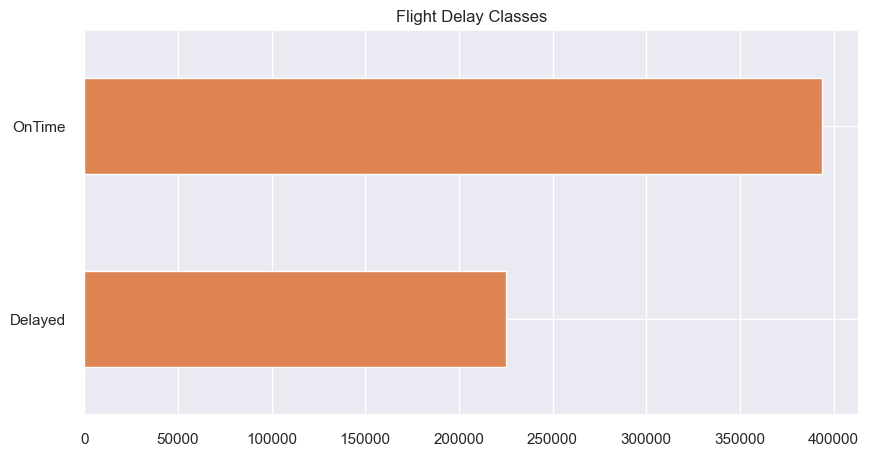

In [20]:
(df_flights
 .DepDelayClass
 .value_counts(ascending=True)
 .plot(kind='barh', figsize=(10,5), color=current_palette[1], title="Flight Delay Classes")
 )
plt.show()

In [21]:
# Is class balanced or imbalanced?
df_flights["DepDelayClass"].value_counts()

OnTime     394001
Delayed    225242
Name: DepDelayClass, dtype: int64

In [22]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619266 entries, 0 to 619265
Data columns (total 45 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   FlightDate             619266 non-null  datetime64[ns]
 1   Operating_Airline      619266 non-null  category      
 2   Tail_Number            619266 non-null  category      
 3   Flight_Number          619266 non-null  int16         
 4   OriginAirportID        619266 non-null  int16         
 5   Origin                 619266 non-null  category      
 6   OriginCityName         619266 non-null  category      
 7   OriginState            619266 non-null  category      
 8   OriginStateName        619266 non-null  category      
 9   DestAirportID          619266 non-null  int16         
 10  Dest                   619266 non-null  category      
 11  DestCityName           619266 non-null  category      
 12  DestState              619266 non-null  cate

Feature Analysis
- Feature importance & Selection

In [23]:
#df_flights.columns.to_list()

In [24]:
####Feature Selection#####
ml_cols = [
    #'FlightDate',
    #'Operating_Airline',
    #'Tail_Number',
    'Flight_Number',
    'OriginAirportID',
    #'Origin',
    #'OriginCityName',
    #'OriginState',
    #'OriginStateName',
    'DestAirportID',
    #'Dest',
    #'DestCityName',
    #'DestState',
    #'DestStateName',
    'CRSDepTime',
    'DepTime',
    #'DepDelay',
    #'DepDel15',
    #'DepDelayMinutes',
    #'DepTimeBlk',
    'TaxiOut',
    'WheelsOn',
    'TaxiIn',
    'CRSArrTime',
    #'ArrTime',
    #'ArrDelayMinutes',
    #'ArrDel15',
    #'ArrTimeBlk',
    #'Cancelled',
    #'CancellationCode',
    #'Diverted',
    'CRSElapsedTime',
    'AirTime',
    'Distance',
    #'CarrierDelay',
    #'WeatherDelay',
    #'NASDelay',
    #'SecurityDelay',
    #'LateAircraftDelay',
    #'FirstDepTime',
    'TotalAddGTime',
    #'latitude',
    #'longitude',
    #'DepDelayClass',
    'DepDelayClass_ordinal'
    ]

df_flights_2= df_flights[ml_cols]
df_flights_2 = df_flights_2[df_flights_2["DepDelayClass_ordinal"].notna()]
df_flights_2.columns

Index(['Flight_Number', 'OriginAirportID', 'DestAirportID', 'CRSDepTime',
       'DepTime', 'TaxiOut', 'WheelsOn', 'TaxiIn', 'CRSArrTime',
       'CRSElapsedTime', 'AirTime', 'Distance', 'TotalAddGTime',
       'DepDelayClass_ordinal'],
      dtype='object')

In [25]:
df_flights_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619243 entries, 0 to 619265
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Flight_Number          619243 non-null  int16  
 1   OriginAirportID        619243 non-null  int16  
 2   DestAirportID          619243 non-null  int16  
 3   CRSDepTime             619243 non-null  int16  
 4   DepTime                619243 non-null  float16
 5   TaxiOut                619243 non-null  float16
 6   WheelsOn               619243 non-null  float16
 7   TaxiIn                 619243 non-null  float16
 8   CRSArrTime             619243 non-null  int16  
 9   CRSElapsedTime         619243 non-null  float16
 10  AirTime                619243 non-null  float16
 11  Distance               619243 non-null  float16
 12  TotalAddGTime          619243 non-null  float16
 13  DepDelayClass_ordinal  619243 non-null  float16
dtypes: float16(9), int16(5)
memory usage

In [26]:
df_flights_2.head()

,Flight_Number,OriginAirportID,DestAirportID,CRSDepTime,DepTime,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,CRSElapsedTime,AirTime,Distance,TotalAddGTime,DepDelayClass_ordinal
0,3298,10397,10146,1037,0.0,0.0,0.0,0.0,1137,60.0,0.0,145.0,0.0,1.0
1,3300,12953,15096,1810,1758.0,24.0,1857.0,6.0,1928,78.0,35.0,198.0,0.0,0.0
2,3302,11641,10397,1853,1850.0,14.0,2005.0,16.0,2030,97.0,61.0,331.0,0.0,0.0
3,3302,13487,11066,1536,1530.0,23.0,1813.0,5.0,1830,114.0,80.0,626.0,0.0,0.0
4,3307,10397,11617,1951,1945.0,24.0,2110.0,1.0,2120,89.0,61.0,433.0,0.0,0.0


Extract independent & dependent variables

In [27]:
#df_flights_2.columns.to_list()

In [28]:
X = df_flights_2[['Flight_Number',
                  'OriginAirportID',
                  'DestAirportID',
                  'CRSDepTime',
                  'DepTime',
                  'TaxiOut',
                  'WheelsOn',
                  'TaxiIn',
                  'CRSArrTime',
                  'CRSElapsedTime',
                  'AirTime',
                  'Distance',
                  'TotalAddGTime']] # independent features
y = df_flights_2['DepDelayClass_ordinal'] # dependent feature

print('X shape: {}'.format(np.shape(X)))
print('y shape: {}'.format(np.shape(y)))

X shape: (619243, 13)
y shape: (619243,)


Feature importance

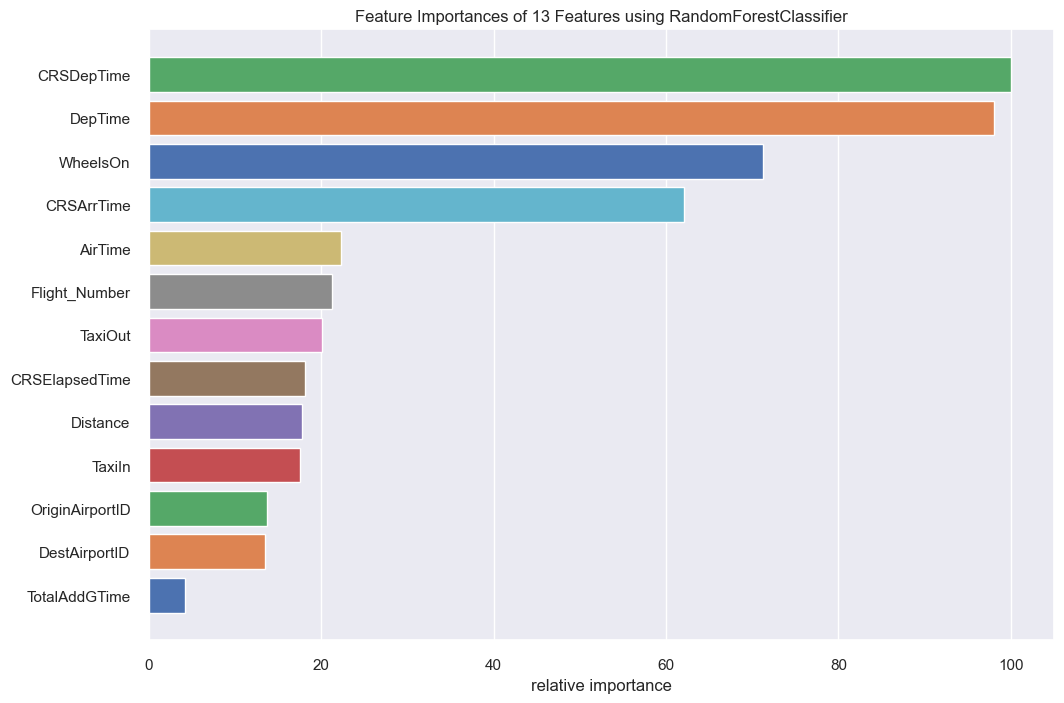

<AxesSubplot: title={'center': 'Feature Importances of 13 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [29]:
features = ['Flight_Number','OriginAirportID','DestAirportID','CRSDepTime','DepTime','TaxiOut','WheelsOn','TaxiIn','CRSArrTime','CRSElapsedTime','AirTime','Distance','TotalAddGTime']
model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(model, labels=features, size=(1080, 720))

viz.fit(X, y)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.show()

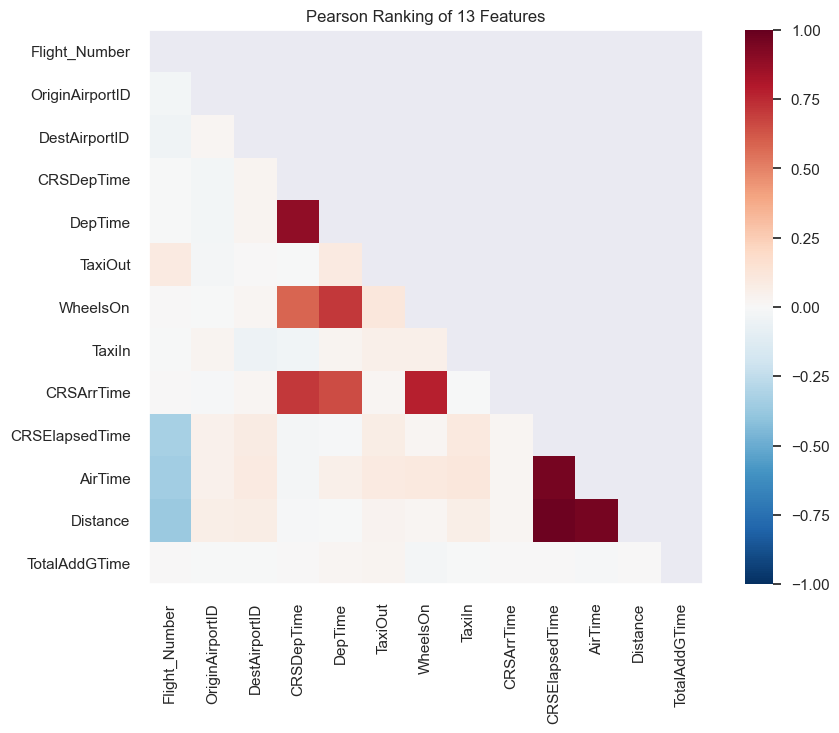

<AxesSubplot: title={'center': 'Pearson Ranking of 13 Features'}>

In [30]:
# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', features=features, size=(1080, 720))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

In [31]:
# Check to see if dataset is imbalanced
y.value_counts(dropna=False)

0.0    394001
1.0    225242
Name: DepDelayClass_ordinal, dtype: int64

In [32]:
df_flights_2.dtypes

Flight_Number              int16
OriginAirportID            int16
DestAirportID              int16
CRSDepTime                 int16
DepTime                  float16
TaxiOut                  float16
WheelsOn                 float16
TaxiIn                   float16
CRSArrTime                 int16
CRSElapsedTime           float16
AirTime                  float16
Distance                 float16
TotalAddGTime            float16
DepDelayClass_ordinal    float16
dtype: object

In [33]:
df_flights_2.shape

(619243, 14)

In [34]:
df_flights_2.describe()

,Flight_Number,OriginAirportID,DestAirportID,CRSDepTime,DepTime,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,CRSElapsedTime,AirTime,Distance,TotalAddGTime,DepDelayClass_ordinal
count,619243.000000,619243.000000,619243.000000,619243.000000,619243.0,619243.0,619243.0,619243.0,619243.000000,619243.0,619243.0,619243.0,619243.0,619243.0
mean,2682.005839,12677.159270,12679.452958,1329.041021,NaN,NaN,NaN,NaN,1487.910796,NaN,NaN,NaN,NaN,NaN
std,1836.135546,1521.373177,1522.991208,486.704192,NaN,0.0,NaN,0.0,513.083125,NaN,NaN,NaN,NaN,0.0
min,1.000000,10135.000000,10135.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,-35.0,0.0,16.0,0.0,0.0
25%,1100.000000,11292.000000,11292.000000,915.000000,901.0,11.0,1031.0,4.0,1105.000000,88.0,57.0,356.0,0.0,0.0
50%,2285.000000,12889.000000,12889.000000,1320.000000,1315.0,14.0,1449.0,6.0,1515.000000,121.0,90.0,629.0,0.0,0.0
75%,4230.000000,14057.000000,14057.000000,1733.000000,1737.0,19.0,1903.0,9.0,1918.000000,170.0,138.0,1020.0,0.0,1.0
max,9665.000000,16869.000000,16869.000000,2359.000000,2400.0,178.0,2400.0,211.0,2400.000000,1538.0,669.0,5812.0,297.0,1.0


Observations from above analysis
- There is a similarity between these 3 features `CRSElapsedTime`,`AirTime`,`Distance`.  
- Only one of these features will be included, that will be `AirTime` based on the Feature importance analysis